In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# Configuration
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
# Set matplotlib to appear in the notebook and display the graph under the appropriate cell
%matplotlib inline  

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Library Deep Learning (DL)
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop, AdamW, Adafactor, Nadam
from tensorflow.keras.utils import to_categorical

# Convolutional Neural Network (CNN)
from keras.layers import Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# Manipulate the compressed image and get a numpy array of image pixel values.
import cv2                  
import numpy as np  
import itertools
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


In [2]:
X=[]
Z=[]
IMG_SIZE = 300
Orange='/kaggle/input/darah-menstruasi/Orange'
Pink='/kaggle/input/darah-menstruasi/Pink'
Abu_Abu='/kaggle/input/darah-menstruasi/abu-abu'
Coklat='/kaggle/input/darah-menstruasi/coklat'
Hitam='/kaggle/input/darah-menstruasi/hitam'
Merah='/kaggle/input/darah-menstruasi/merah'



In [3]:
def assign_label(img,warna_type):
    return warna_type

In [4]:
def make_train_data(warna_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,warna_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
make_train_data('Orange',Orange)
print(len(X))
make_train_data('Pink',Pink)
print(len(X))
make_train_data('Abu_Abu',Abu_Abu)
print(len(X))
make_train_data('Coklat',Coklat)
print(len(X))
make_train_data('Hitam',Hitam)
print(len(X))
make_train_data('Merah',Merah)
print(len(X))

100%|██████████| 100/100 [00:01<00:00, 95.66it/s]


100


100%|██████████| 100/100 [00:00<00:00, 102.20it/s]


200


100%|██████████| 100/100 [00:00<00:00, 107.34it/s]


300


100%|██████████| 100/100 [00:01<00:00, 99.30it/s]


400


100%|██████████| 100/100 [00:00<00:00, 108.76it/s]


500


100%|██████████| 100/100 [00:00<00:00, 105.15it/s]

600


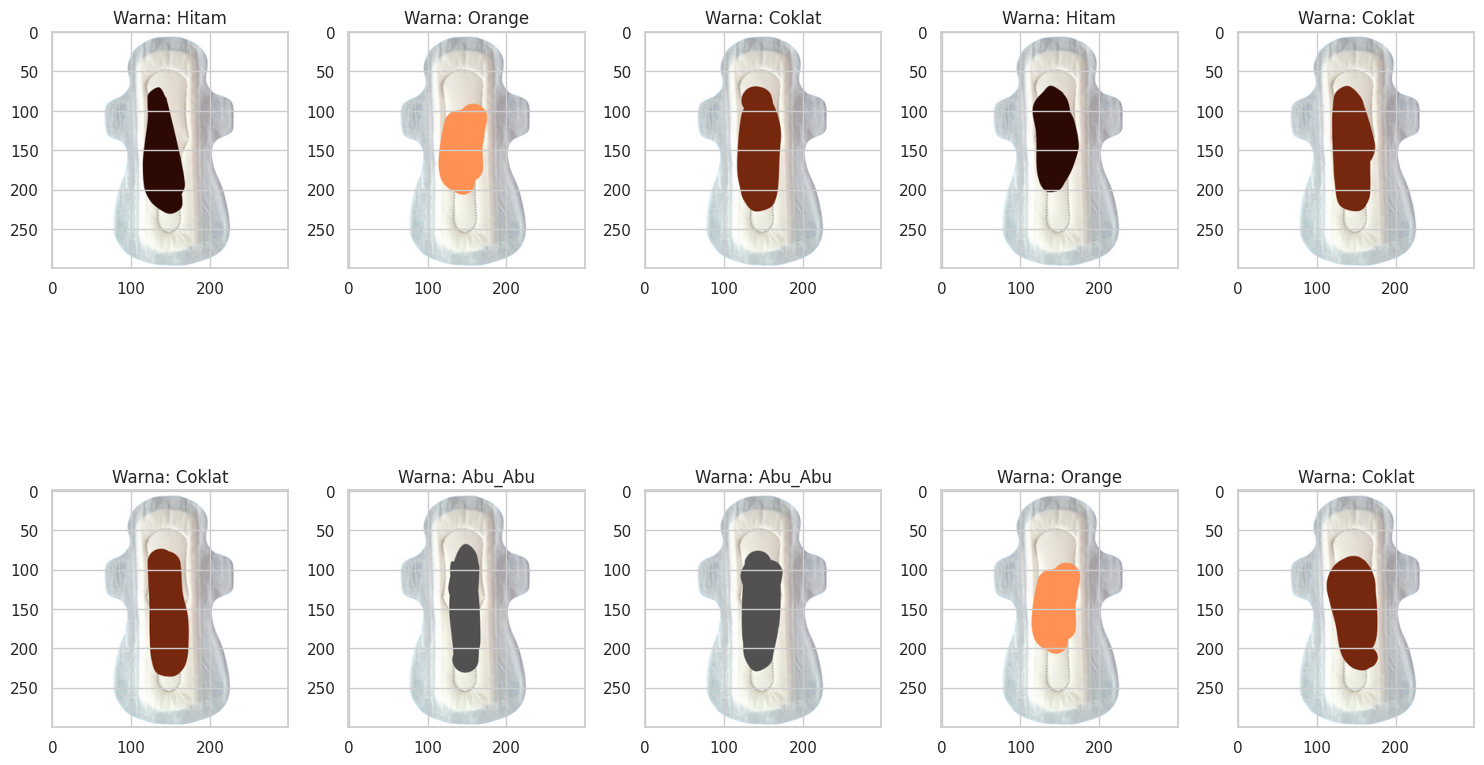

In [6]:
fig,ax=plt.subplots(2,5)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Warna: '+Z[l])
        plt.tight_layout()

In [7]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,6)
X=np.array(X)
X=X/255

In [8]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)

In [9]:
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 1, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 
datagen.fit(x_train)

In [10]:
np.random.seed(7)
rn.seed(7)
tf.random.set_seed(7)

In [11]:
from tensorflow.keras.applications import MobileNet

# Loads a pre-trained MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Turns off learning on previously trained layers
mobilenet.trainable = False

# Create a new model
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(6, activation='softmax')
])

17225924/17225924 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 9, 9, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [13]:
model.compile(optimizer=Nadam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
import time
from tensorflow.keras.callbacks import Callback

# Callback to measure training time
class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        minutes = int(elapsed_time / 60)
        seconds = int(elapsed_time % 60)
        print(f"\nTotal training time: {minutes} minutes {seconds} seconds")

# Main program
batch = 16
epoch = 50
step = np.ceil(x_train.shape[0] / batch)

# Callback for training time
timing_callback = TimingCallback()

History = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch),
                              epochs=epoch,
                              validation_data=(x_test, y_test),
                              verbose=1,
                              steps_per_epoch=step,
                              callbacks=[timing_callback])


Epoch 1/50
30/30 [==============================] - 27s 381ms/step - loss: 1.7028 - accuracy: 0.3125 - val_loss: 1.4116 - val_accuracy: 0.5167
Epoch 2/50
30/30 [==============================] - 10s 322ms/step - loss: 1.3665 - accuracy: 0.4833 - val_loss: 0.9923 - val_accuracy: 0.6500
Epoch 3/50
30/30 [==============================] - 10s 324ms/step - loss: 1.0447 - accuracy: 0.6521 - val_loss: 0.6878 - val_accuracy: 0.7250
Epoch 4/50
30/30 [==============================] - 10s 325ms/step - loss: 0.8415 - accuracy: 0.6854 - val_loss: 0.6500 - val_accuracy: 0.7333
Epoch 5/50
30/30 [==============================] - 10s 323ms/step - loss: 0.7126 - accuracy: 0.7146 - val_loss: 0.4590 - val_accuracy: 0.7583
Epoch 6/50
30/30 [==============================] - 10s 320ms/step - loss: 0.6174 - accuracy: 0.7375 - val_loss: 0.4122 - val_accuracy: 0.8250
Epoch 7/50
30/30 [==============================] - 10s 322ms/step - loss: 0.6034 - accuracy: 0.7437 - val_loss: 0.4009 - val_accuracy: 0.8000

In [15]:
model.save('klasifikasiwarna.h5')

In [16]:
target_names = ['Orange','Pink','Abu-Abu','Coklat','Hitam','Merah']

In [17]:
Y_pred = model.predict_generator(x_test)
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 1  0 19  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0  0  0  0 18  2]
 [ 0  0  0  0  0 20]]


In [18]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Orange       0.95      1.00      0.98        20
        Pink       1.00      1.00      1.00        20
     Abu-Abu       1.00      0.95      0.97        20
      Coklat       1.00      1.00      1.00        20
       Hitam       1.00      0.90      0.95        20
       Merah       0.91      1.00      0.95        20

    accuracy                           0.97       120
   macro avg       0.98      0.98      0.97       120
weighted avg       0.98      0.97      0.97       120



In [19]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


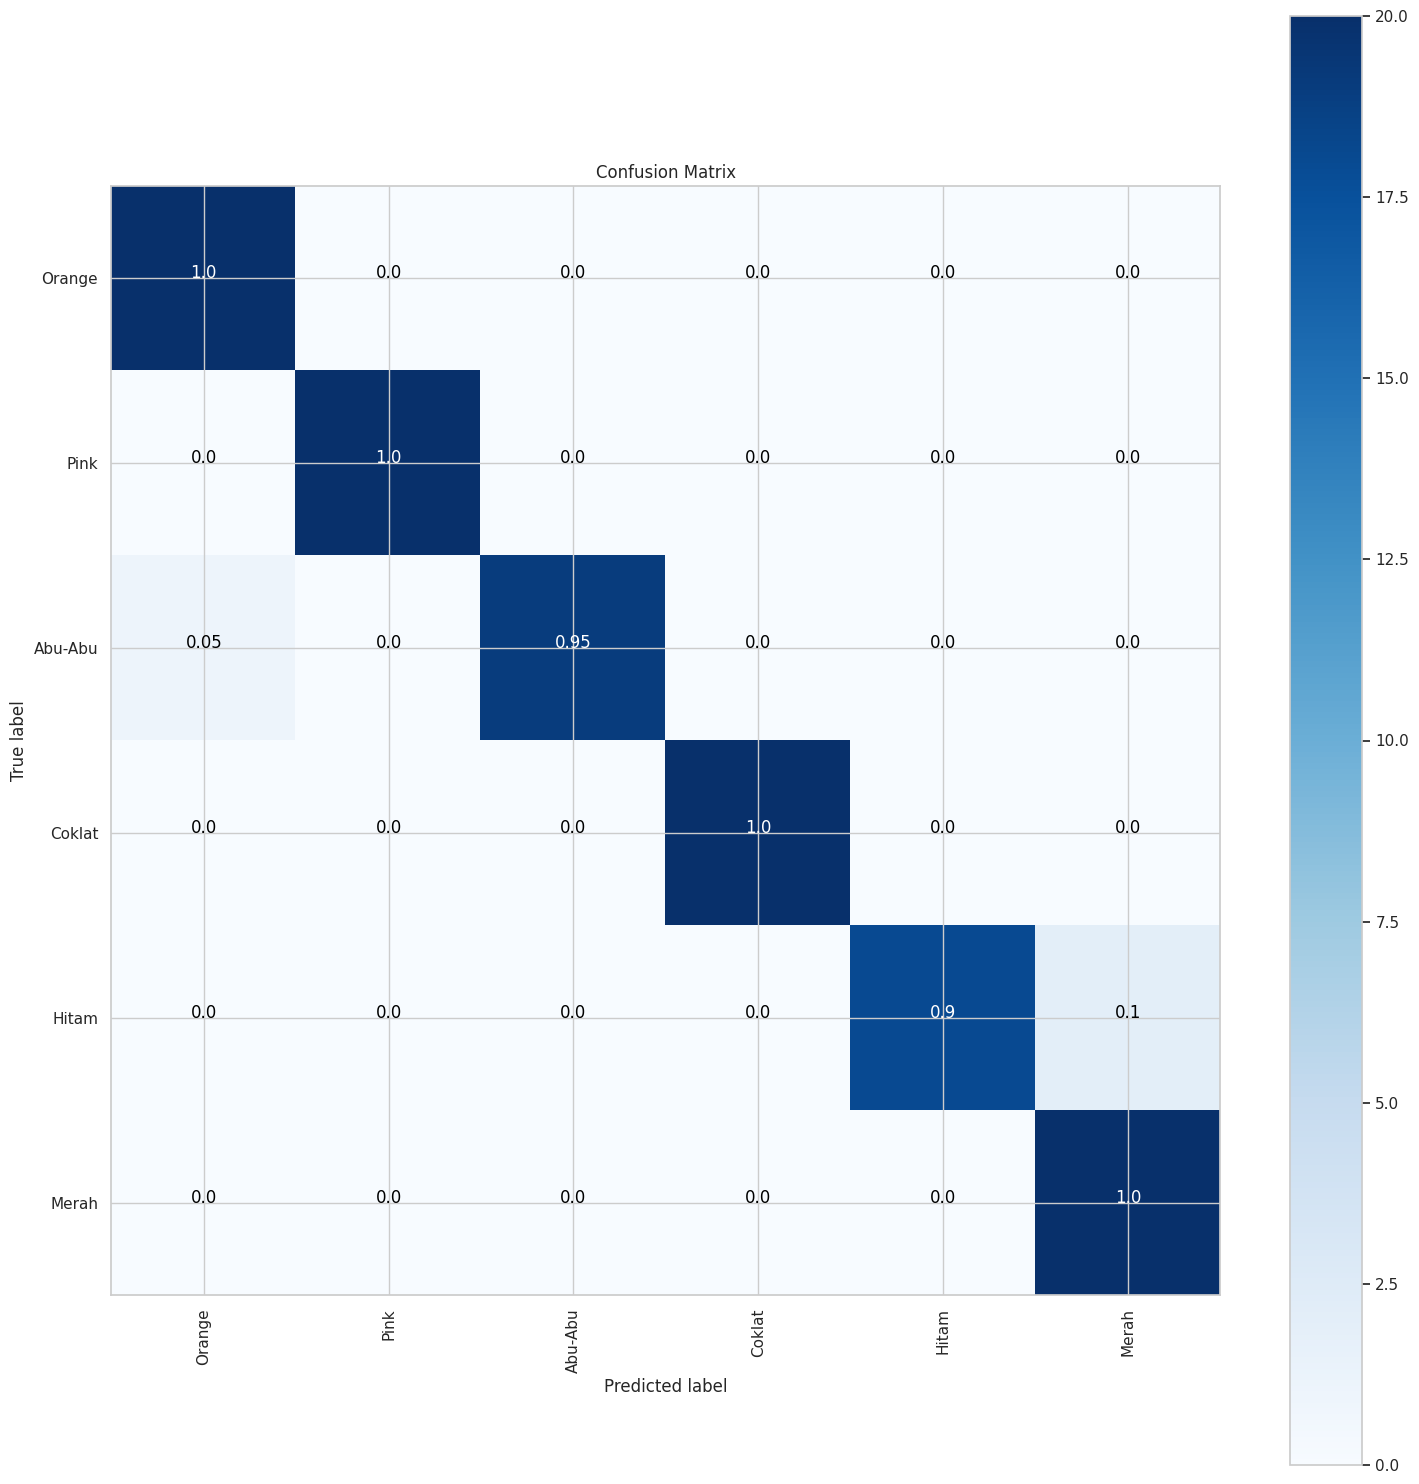

In [20]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

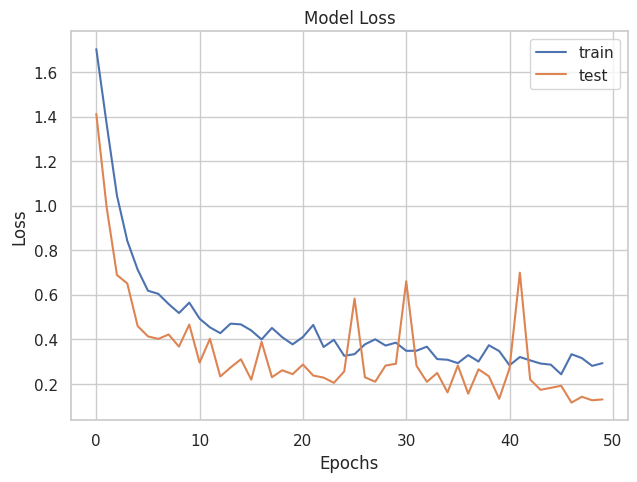

In [21]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

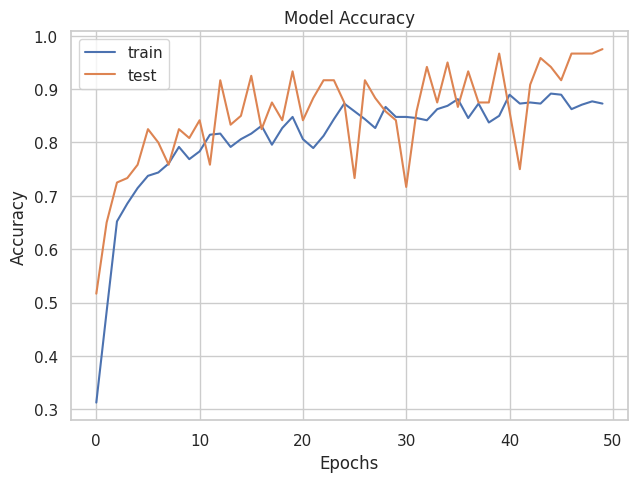

In [22]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Masukkan path file gambar:  /kaggle/input/darah-menstruasi/Pink/11.png


1/1 [==============================] - 0s 26ms/step


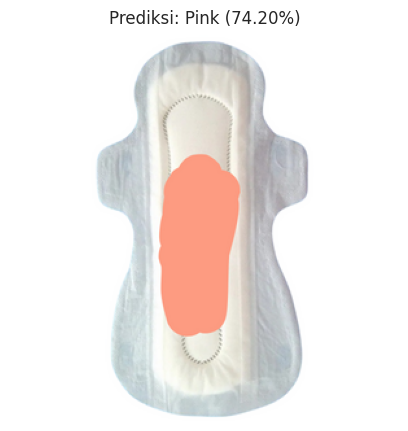

In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to get class labels based on index
def get_class_label(class_index):
    if class_index == 0:
        return "Abu-Abu"
    elif class_index == 1:
        return "Coklat"
    elif class_index == 2:
        return "Hitam"
    elif class_index == 3:
        return "Merah"
    elif class_index == 4:
        return "Orange"
    elif class_index == 5:
        return "Pink"


# Load the image to be predicted
image_path = input("Masukkan path file gambar: ")

# Load image
img = image.load_img(image_path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalisasi gambar

# Make predictions
predictions = model.predict(x)
class_index = np.argmax(predictions)
class_label = get_class_label(class_index)
confidence = predictions[0][class_index] * 100

# Displays images and prediction results
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_label} ({confidence:.2f}%)")
plt.show()


In [28]:
!tensorflowjs_converter --input_format keras /kaggle/working/klasifikasiwarna.h5 /kaggle/working/tfjs_model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
